In [1]:
!pip install pandas
!pip install seaborn

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pyspark.sql import SparkSession
from sklearn import cluster
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering  import  KMeans
from pyspark.ml.classification import LogisticRegression


warnings.filterwarnings('ignore')
spark = SparkSession.builder.appName('Anlysis weather in AUS').getOrCreate()

In [123]:
#get the file from hdfs
df = spark.read.csv('hdfs://namenode/weatherAUS.csv', header = True, inferSchema = True,)

In [124]:
print((df.count(), len(df.columns)))

(145460, 23)


# Data preparation

## Step1: get data that we need

In [125]:
#transfer the saprk dataframe into pandas dataframe
newdf = df.toPandas()

In [126]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Date           145460 non-null  object
 1   Location       145460 non-null  object
 2   MinTemp        145460 non-null  object
 3   MaxTemp        145460 non-null  object
 4   Rainfall       145460 non-null  object
 5   Evaporation    145460 non-null  object
 6   Sunshine       145460 non-null  object
 7   WindGustDir    145460 non-null  object
 8   WindGustSpeed  145460 non-null  object
 9   WindDir9am     145460 non-null  object
 10  WindDir3pm     145460 non-null  object
 11  WindSpeed9am   145460 non-null  object
 12  WindSpeed3pm   145460 non-null  object
 13  Humidity9am    145460 non-null  object
 14  Humidity3pm    145460 non-null  object
 15  Pressure9am    145460 non-null  object
 16  Pressure3pm    145460 non-null  object
 17  Cloud9am       145460 non-null  object
 18  Clou

In [127]:
#Get the column that we need 
datadf = newdf[["Date","Location","MinTemp","MaxTemp",
            "Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm",
            "Humidity9am", "Humidity3pm","Pressure9am",
            "Pressure3pm", "Cloud9am","Cloud3pm","Temp9am", "Temp3pm","RainToday", 
            "RainTomorrow"]]

In [128]:
datadf.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,44,20,24,71,22,1007.7,1007.1,8,NA,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0,44,4,22,44,25,1010.6,1007.8,NA,NA,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0,46,19,26,38,30,1007.6,1008.7,NA,2,21,23.2,No,No
3,2008-12-04,Albury,9.2,28,0,24,11,9,45,16,1017.6,1012.8,NA,NA,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1,41,7,20,82,33,1010.8,1006,7,8,17.8,29.7,No,No


## Step2: Data clean

### (1) Estimate wheather  there exist the null value in dataset

In [129]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Date           145460 non-null  object
 1   Location       145460 non-null  object
 2   MinTemp        145460 non-null  object
 3   MaxTemp        145460 non-null  object
 4   Rainfall       145460 non-null  object
 5   WindGustSpeed  145460 non-null  object
 6   WindSpeed9am   145460 non-null  object
 7   WindSpeed3pm   145460 non-null  object
 8   Humidity9am    145460 non-null  object
 9   Humidity3pm    145460 non-null  object
 10  Pressure9am    145460 non-null  object
 11  Pressure3pm    145460 non-null  object
 12  Cloud9am       145460 non-null  object
 13  Cloud3pm       145460 non-null  object
 14  Temp9am        145460 non-null  object
 15  Temp3pm        145460 non-null  object
 16  RainToday      145460 non-null  object
 17  RainTomorrow   145460 non-null  object
dtypes: o

### There is no null value in datatset

### (2) Drop NA value

In [130]:
columns_need = ["Date","Location","MinTemp","MaxTemp",
            "Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm",
            "Humidity9am", "Humidity3pm","Pressure9am",
            "Pressure3pm", "Cloud9am","Cloud3pm","Temp9am", "Temp3pm","RainToday", 
            "RainTomorrow"]

* Since the number of files is large enough, we can directly delete the rows whose data contains NA

In [131]:
for i in columns_need:
    datadf = datadf.drop(datadf[datadf[i] == 'NA'].index)
datadf.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
4,2008-12-05,Albury,17.5,32.3,1,41,7,20,82,33,1010.8,1006,7,8,17.8,29.7,No,No
11,2008-12-12,Albury,15.9,21.7,2.2,31,15,13,89,91,1010.5,1004.2,8,8,15.9,17,Yes,Yes
12,2008-12-13,Albury,15.9,18.6,15.6,61,28,28,76,93,994.3,993,8,8,17.4,15.8,Yes,Yes
16,2008-12-17,Albury,14.1,20.9,0,22,11,9,69,82,1012.2,1010.4,8,1,17.2,18.1,No,Yes
17,2008-12-18,Albury,13.5,22.9,16.8,63,6,20,80,65,1005.8,1002.2,8,1,18,21.5,Yes,Yes


In [132]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 4 to 145458
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           73411 non-null  object
 1   Location       73411 non-null  object
 2   MinTemp        73411 non-null  object
 3   MaxTemp        73411 non-null  object
 4   Rainfall       73411 non-null  object
 5   WindGustSpeed  73411 non-null  object
 6   WindSpeed9am   73411 non-null  object
 7   WindSpeed3pm   73411 non-null  object
 8   Humidity9am    73411 non-null  object
 9   Humidity3pm    73411 non-null  object
 10  Pressure9am    73411 non-null  object
 11  Pressure3pm    73411 non-null  object
 12  Cloud9am       73411 non-null  object
 13  Cloud3pm       73411 non-null  object
 14  Temp9am        73411 non-null  object
 15  Temp3pm        73411 non-null  object
 16  RainToday      73411 non-null  object
 17  RainTomorrow   73411 non-null  object
dtypes: object(18)
memory usag

The data size is 73411 >10000 after clean the original dataset

## step3: Change the 'Date' into date form --year,month,day and drop the 'Date' attributes

In [133]:
data_df = datadf

In [134]:
#Date is strings type, change them into datetime format
data_df['Date'] = pd.to_datetime(data_df['Date'])

In [135]:
data_df['Year'] = data_df['Date'].dt.year
data_df['Month'] = data_df['Date'].dt.month
data_df['Day'] = data_df['Date'].dt.day

In [136]:
data_df.drop('Date', axis=1, inplace = True)
data_df.head(5)

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
4,Albury,17.5,32.3,1,41,7,20,82,33,1010.8,1006,7,8,17.8,29.7,No,No,2008,12,5
11,Albury,15.9,21.7,2.2,31,15,13,89,91,1010.5,1004.2,8,8,15.9,17,Yes,Yes,2008,12,12
12,Albury,15.9,18.6,15.6,61,28,28,76,93,994.3,993,8,8,17.4,15.8,Yes,Yes,2008,12,13
16,Albury,14.1,20.9,0,22,11,9,69,82,1012.2,1010.4,8,1,17.2,18.1,No,Yes,2008,12,17
17,Albury,13.5,22.9,16.8,63,6,20,80,65,1005.8,1002.2,8,1,18,21.5,Yes,Yes,2008,12,18


In [137]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 4 to 145458
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       73411 non-null  object
 1   MinTemp        73411 non-null  object
 2   MaxTemp        73411 non-null  object
 3   Rainfall       73411 non-null  object
 4   WindGustSpeed  73411 non-null  object
 5   WindSpeed9am   73411 non-null  object
 6   WindSpeed3pm   73411 non-null  object
 7   Humidity9am    73411 non-null  object
 8   Humidity3pm    73411 non-null  object
 9   Pressure9am    73411 non-null  object
 10  Pressure3pm    73411 non-null  object
 11  Cloud9am       73411 non-null  object
 12  Cloud3pm       73411 non-null  object
 13  Temp9am        73411 non-null  object
 14  Temp3pm        73411 non-null  object
 15  RainToday      73411 non-null  object
 16  RainTomorrow   73411 non-null  object
 17  Year           73411 non-null  int64 
 18  Month          73411 non-

## step4: Encoding the 'RainToday' and 'RainTomorrow'

In [138]:
# get the values that exist in 'RainToday'
data_df.RainToday.unique()

array(['No', 'Yes'], dtype=object)

In [139]:
# get the values that exist in 'RainTomorrow'
data_df.RainTomorrow.unique()

array(['No', 'Yes'], dtype=object)

In [140]:
dictionary = {'No': 0, 'Yes': 1}
data_df['RainToday'] = data_df['RainToday'].map(dictionary)
data_df['RainTomorrow'] = data_df['RainTomorrow'].map(dictionary)
data_df.head(5)

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
4,Albury,17.5,32.3,1,41,7,20,82,33,1010.8,1006,7,8,17.8,29.7,0,0,2008,12,5
11,Albury,15.9,21.7,2.2,31,15,13,89,91,1010.5,1004.2,8,8,15.9,17,1,1,2008,12,12
12,Albury,15.9,18.6,15.6,61,28,28,76,93,994.3,993,8,8,17.4,15.8,1,1,2008,12,13
16,Albury,14.1,20.9,0,22,11,9,69,82,1012.2,1010.4,8,1,17.2,18.1,0,1,2008,12,17
17,Albury,13.5,22.9,16.8,63,6,20,80,65,1005.8,1002.2,8,1,18,21.5,1,1,2008,12,18


In [141]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 4 to 145458
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       73411 non-null  object
 1   MinTemp        73411 non-null  object
 2   MaxTemp        73411 non-null  object
 3   Rainfall       73411 non-null  object
 4   WindGustSpeed  73411 non-null  object
 5   WindSpeed9am   73411 non-null  object
 6   WindSpeed3pm   73411 non-null  object
 7   Humidity9am    73411 non-null  object
 8   Humidity3pm    73411 non-null  object
 9   Pressure9am    73411 non-null  object
 10  Pressure3pm    73411 non-null  object
 11  Cloud9am       73411 non-null  object
 12  Cloud3pm       73411 non-null  object
 13  Temp9am        73411 non-null  object
 14  Temp3pm        73411 non-null  object
 15  RainToday      73411 non-null  int64 
 16  RainTomorrow   73411 non-null  int64 
 17  Year           73411 non-null  int64 
 18  Month          73411 non-

## Step5: Change the rest attributes (Except the 'location')  into numeric data 

In [142]:
columns_numeric = ["MinTemp","MaxTemp",
            "Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm",
            "Humidity9am", "Humidity3pm","Pressure9am",
            "Pressure3pm", "Cloud9am","Cloud3pm","Temp9am", "Temp3pm"
]
for i in columns_numeric:
    data_df[i] = pd.to_numeric(data_df[i])

In [143]:
data_df.head(5)

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
4,Albury,17.5,32.3,1.0,41,7,20,82,33,1010.8,1006.0,7,8,17.8,29.7,0,0,2008,12,5
11,Albury,15.9,21.7,2.2,31,15,13,89,91,1010.5,1004.2,8,8,15.9,17.0,1,1,2008,12,12
12,Albury,15.9,18.6,15.6,61,28,28,76,93,994.3,993.0,8,8,17.4,15.8,1,1,2008,12,13
16,Albury,14.1,20.9,0.0,22,11,9,69,82,1012.2,1010.4,8,1,17.2,18.1,0,1,2008,12,17
17,Albury,13.5,22.9,16.8,63,6,20,80,65,1005.8,1002.2,8,1,18.0,21.5,1,1,2008,12,18


In [144]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 4 to 145458
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       73411 non-null  object 
 1   MinTemp        73411 non-null  float64
 2   MaxTemp        73411 non-null  float64
 3   Rainfall       73411 non-null  float64
 4   WindGustSpeed  73411 non-null  int64  
 5   WindSpeed9am   73411 non-null  int64  
 6   WindSpeed3pm   73411 non-null  int64  
 7   Humidity9am    73411 non-null  int64  
 8   Humidity3pm    73411 non-null  int64  
 9   Pressure9am    73411 non-null  float64
 10  Pressure3pm    73411 non-null  float64
 11  Cloud9am       73411 non-null  int64  
 12  Cloud3pm       73411 non-null  int64  
 13  Temp9am        73411 non-null  float64
 14  Temp3pm        73411 non-null  float64
 15  RainToday      73411 non-null  int64  
 16  RainTomorrow   73411 non-null  int64  
 17  Year           73411 non-null  int64  
 18  Month

* Now there only the 'location' is object type.The other attributes are all became into numeric data.

## step4: Encode the 'Location' 

In [145]:
# get the values that exist in 'location'
data_df.Location.unique()

array(['Albury', 'Cobar', 'CoffsHarbour', 'Moree', 'NorfolkIsland',
       'Richmond', 'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Ballarat', 'Bendigo', 'Sale',
       'MelbourneAirport', 'Melbourne', 'Mildura', 'Portland', 'Watsonia',
       'Brisbane', 'Cairns', 'Townsville', 'MountGambier', 'Nuriootpa',
       'Woomera', 'PearceRAAF', 'PerthAirport', 'Perth', 'Hobart',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [146]:
columns_data = ["MinTemp","MaxTemp",
            "Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm",
            "Humidity9am", "Humidity3pm","Pressure9am",
            "Pressure3pm", "Cloud9am","Cloud3pm","Temp9am", "Temp3pm","RainToday", 
            "RainTomorrow",'Year','Month','Day']

In [147]:
data_df = pd.concat([data_df[columns_data],
                     pd.get_dummies(data_df.Location)], axis=1)

In [148]:
data_df.head(5)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,Sale,Sydney,SydneyAirport,Townsville,Uluru,WaggaWagga,Watsonia,Williamtown,Wollongong,Woomera
4,17.5,32.3,1.0,41,7,20,82,33,1010.8,1006.0,...,0,0,0,0,0,0,0,0,0,0
11,15.9,21.7,2.2,31,15,13,89,91,1010.5,1004.2,...,0,0,0,0,0,0,0,0,0,0
12,15.9,18.6,15.6,61,28,28,76,93,994.3,993.0,...,0,0,0,0,0,0,0,0,0,0
16,14.1,20.9,0.0,22,11,9,69,82,1012.2,1010.4,...,0,0,0,0,0,0,0,0,0,0
17,13.5,22.9,16.8,63,6,20,80,65,1005.8,1002.2,...,0,0,0,0,0,0,0,0,0,0


# Analysis data

## Univariate Analysis

### (1) Use Histogram to show the frequency of 'No' or 'Yes' of `RainTomorrow`

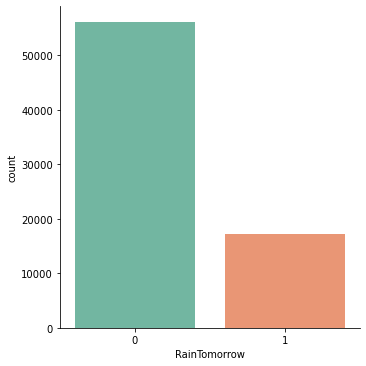

In [149]:
#'No': 0, 'Yes': 1
sns.catplot(x="RainTomorrow", data=data_df, kind='count',palette="Set2")

In [150]:
data_df['RainTomorrow'].value_counts()/len(data_df)

0    0.765131
1    0.234869
Name: RainTomorrow, dtype: float64

We can see that`'No' : 0 ` appears 76.5% , and `'Yes' : 1` appears 23.5% times.

##  Use heatmap to show the correlation between each variables 

In [151]:
correlation = data_df[["MinTemp","MaxTemp",
            "Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm",
            "Humidity9am", "Humidity3pm","Pressure9am",
            "Pressure3pm", "Cloud9am","Cloud3pm","Temp9am", "Temp3pm","RainToday", 
            "RainTomorrow"]].corr()

<AxesSubplot:title={'center':'Correlation Heatmap of wheather in Australia'}>

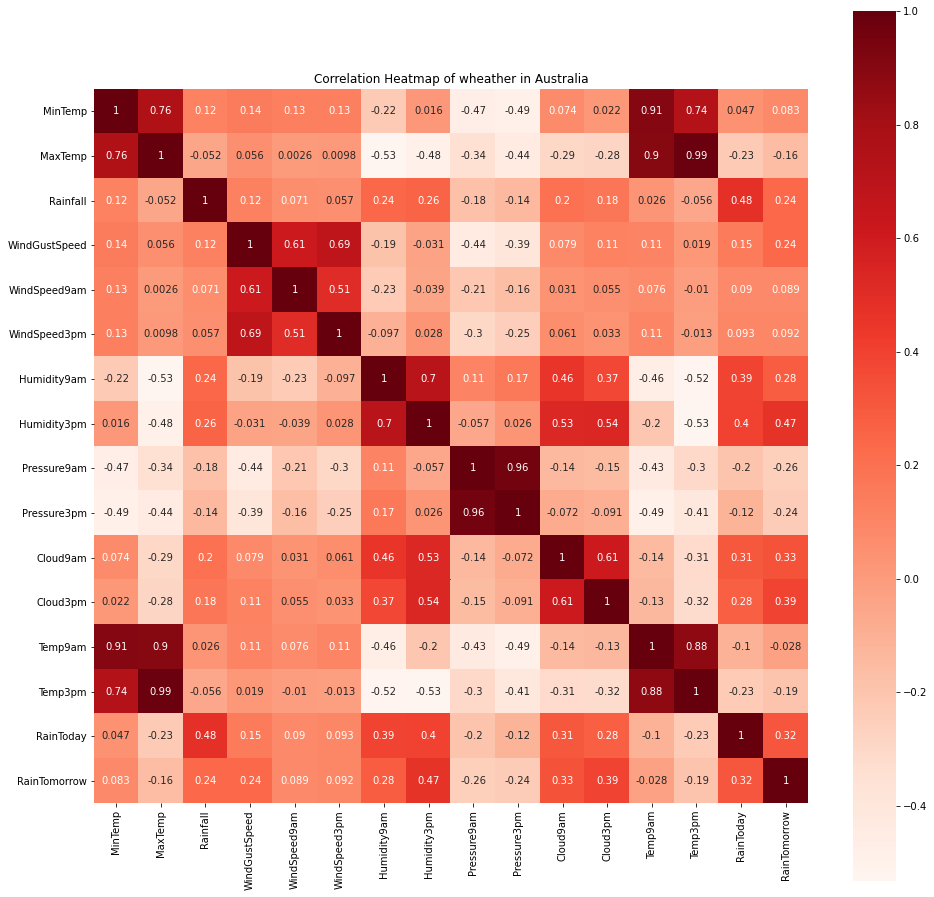

In [152]:
plt.subplots(figsize = (16,16))
plt.title('Correlation Heatmap of wheather in Australia')
sns.heatmap(correlation,annot = True,vmax = 1,square = True,cmap = "Reds",linecolor='white')

## As can be seen from the figure:

### observation:
* `MaxTemp` and `Temp3pm` variables are also `strongly positively` correlated (correlation coefficient = 0.99).

* `Pressure9am` and `Pressure3pm` variables are `strongly positively` correlated (correlation coefficient = 0.96).

* `MinTemp` and `Temp9am` variables are also `strongly positively` correlated (correlation coefficient = 0.91).

* `MaxTemp` and `Temp9am` variables are `strongly positively` correlated (correlation coefficient = 0.9).

* `Temp3pm` and `Temp9am` variables are `strongly positively` correlated (correlation coefficient = 0.88).

* `MinTemp` and `MaxTemp` variables are `highly positively` correlated (correlation coefficient = 0.76).

* `MinTemp` and `Temp3am` variables are `highly positively` correlated (correlation coefficient = 0.74).

* `Humidity3pm` and `Humidity9pm` variables are `highly positively` correlated (correlation coefficient = 0.7).

* `RainTomorrow` and `Rainfall`,`WindGustSpeed`,`Humidity9am`, `Humidity3pm`, `Cloud9am`,`Cloud3pm`,`RainTomorrow` have relativaly median  correlation

# `Regression`

## Use the `linear Regression` Model

## Step1: Get the data that we need

In [153]:
lr_df = data_df[["MaxTemp", "MinTemp","Temp3pm","Temp9am"]]

In [154]:
spark = SparkSession.builder.getOrCreate()
lr_dfspark = spark.createDataFrame(lr_df)

In [155]:
lr_dfspark.printSchema() 

root
 |-- MaxTemp: double (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- Temp9am: double (nullable = true)



In [156]:
lr_dfspark.show(3)

+-------+-------+-------+-------+
|MaxTemp|MinTemp|Temp3pm|Temp9am|
+-------+-------+-------+-------+
|   32.3|   17.5|   29.7|   17.8|
|   21.7|   15.9|   17.0|   15.9|
|   18.6|   15.9|   15.8|   17.4|
+-------+-------+-------+-------+
only showing top 3 rows



In [157]:
# Select feature items and combine feature items into vectors
from pyspark.ml.feature import VectorAssembler
vecAss = VectorAssembler(inputCols = lr_dfspark.columns[0:4], outputCol = 'features')
df_rl = vecAss.transform(lr_dfspark)
df_rl.show(3)

+-------+-------+-------+-------+--------------------+
|MaxTemp|MinTemp|Temp3pm|Temp9am|            features|
+-------+-------+-------+-------+--------------------+
|   32.3|   17.5|   29.7|   17.8|[32.3,17.5,29.7,1...|
|   21.7|   15.9|   17.0|   15.9|[21.7,15.9,17.0,1...|
|   18.6|   15.9|   15.8|   17.4|[18.6,15.9,15.8,1...|
+-------+-------+-------+-------+--------------------+
only showing top 3 rows



In [158]:
data_rl = df_rl.select(["features","Temp3pm"])
data_rl.show(3)

+--------------------+-------+
|            features|Temp3pm|
+--------------------+-------+
|[32.3,17.5,29.7,1...|   29.7|
|[21.7,15.9,17.0,1...|   17.0|
|[18.6,15.9,15.8,1...|   15.8|
+--------------------+-------+
only showing top 3 rows



## Step2: Train/Test split

In [159]:
# split the data into train-test split where 30% of data will be used as test set
datatrain, datatest = data_rl.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(datatrain.count()))
print("Test Dataset Count: " + str(datatest.count()))

Training Dataset Count: 51288
Test Dataset Count: 22123


In [160]:
datatrain.describe().show()

+-------+------------------+
|summary|           Temp3pm|
+-------+------------------+
|  count|             51288|
|   mean|22.232990173139882|
| stddev| 7.026925895110897|
|    min|               1.7|
|    max|              46.7|
+-------+------------------+



In [161]:
datatest.describe().show()

+-------+------------------+
|summary|           Temp3pm|
+-------+------------------+
|  count|             22123|
|   mean|22.255250192107763|
| stddev|   7.0307139916224|
|    min|               3.2|
|    max|              45.4|
+-------+------------------+



## Step3: Build the linear regression model to prediction the temperature of 3pm in today

In [162]:
from pyspark.ml.regression import LinearRegression
linearRegression = LinearRegression(labelCol="Temp3pm")
lr_model = linearRegression.fit(datatrain)
train_res = lr_model.transform(datatrain)
train_res.show(10)

+------------------+-------+------------------+
|          features|Temp3pm|        prediction|
+------------------+-------+------------------+
|[4.1,-2.2,3.7,0.7]|    3.7| 3.699999999999995|
| [5.2,3.3,4.8,3.7]|    4.8| 4.799999999999992|
| [5.6,0.6,4.3,2.8]|    4.3| 4.300000000000005|
| [6.6,1.0,5.7,1.8]|    5.7| 5.700000000000001|
|[6.7,-2.0,5.4,0.9]|    5.4| 5.400000000000007|
| [6.7,2.3,3.4,4.5]|    3.4|3.4000000000000328|
| [6.8,2.9,4.7,4.2]|    4.7| 4.700000000000015|
| [6.8,4.4,6.4,4.7]|    6.4|6.3999999999999915|
|[6.9,-0.1,6.0,1.4]|    6.0| 6.000000000000001|
| [7.0,0.3,5.2,2.1]|    5.2| 5.200000000000012|
+------------------+-------+------------------+
only showing top 10 rows



In [163]:
test_res = lr_model.transform(datatest)
test_res.show(10)

+-----------------+-------+------------------+
|         features|Temp3pm|        prediction|
+-----------------+-------+------------------+
|[4.6,1.5,3.4,3.3]|    3.4|3.4000000000000035|
|[4.9,0.8,3.2,2.7]|    3.2|3.2000000000000113|
|[5.5,1.3,4.6,3.2]|    4.6| 4.599999999999999|
|[6.3,1.1,6.0,2.1]|    6.0| 5.999999999999991|
|[6.9,4.7,5.9,5.3]|    5.9| 5.899999999999999|
|[7.0,2.5,6.5,5.6]|    6.5| 6.499999999999992|
|[7.1,4.1,6.3,6.3]|    6.3| 6.299999999999995|
|[7.1,5.1,6.4,5.9]|    6.4| 6.399999999999995|
|[7.2,4.8,6.7,6.6]|    6.7| 6.699999999999991|
|[7.2,6.6,5.2,7.2]|    5.2| 5.200000000000012|
+-----------------+-------+------------------+
only showing top 10 rows



## Step4: Evaluation of model

In [164]:
res_test = lr_model.evaluate(datatest)

In [165]:
print("mean_squared_error（MSE）：",res_test.meanSquaredError)
  
print("mean_absolute_error（MAE）：",res_test.meanAbsoluteError)

print("r_square_score（r2_score）：", res_test.r2)

mean_squared_error（MSE）： 2.832934279883897e-28
mean_absolute_error（MAE）： 1.1521287622955896e-14
r_square_score（r2_score）： 1.0


* From the result , It can be seen that this model fits well

# `Clustering`

##  Use K-means to clustering the data

## Step1: Get the data that we need and use Elbow method to get the k value.

In [166]:
numeric_data = data_df[["MinTemp","MaxTemp",
            "Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm",
            "Humidity9am", "Humidity3pm","Pressure9am",
            "Pressure3pm", "Cloud9am","Cloud3pm","Temp9am", "Temp3pm"]]
numeric_data.head(5)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
4,17.5,32.3,1.0,41,7,20,82,33,1010.8,1006.0,7,8,17.8,29.7
11,15.9,21.7,2.2,31,15,13,89,91,1010.5,1004.2,8,8,15.9,17.0
12,15.9,18.6,15.6,61,28,28,76,93,994.3,993.0,8,8,17.4,15.8
16,14.1,20.9,0.0,22,11,9,69,82,1012.2,1010.4,8,1,17.2,18.1
17,13.5,22.9,16.8,63,6,20,80,65,1005.8,1002.2,8,1,18.0,21.5


In [167]:
# standardized data
numeric_data['z_MinTemp']= (numeric_data['MinTemp']-numeric_data['MinTemp'].mean())/numeric_data['MinTemp'].std()
numeric_data['z_MaxTemp']= (numeric_data['MaxTemp']-numeric_data['MaxTemp'].mean())/numeric_data['MaxTemp'].std()
numeric_data['z_Rainfall']= (numeric_data['Rainfall']-numeric_data['Rainfall'].mean())/numeric_data['Rainfall'].std()
numeric_data['z_WindGustSpeed']= (numeric_data['WindGustSpeed']-numeric_data['WindGustSpeed'].mean())/numeric_data['WindGustSpeed'].std()
numeric_data['z_WindSpeed9am']= (numeric_data['WindSpeed9am']-numeric_data['WindSpeed9am'].mean())/numeric_data['WindSpeed9am'].std()
numeric_data['z_WindSpeed3pm']= (numeric_data['WindSpeed3pm']-numeric_data['WindSpeed3pm'].mean())/numeric_data['WindSpeed3pm'].std()
numeric_data['z_Humidity9am']= (numeric_data['Humidity9am']-numeric_data['Humidity9am'].mean())/numeric_data['Humidity9am'].std()
numeric_data['z_Humidity3pm']= (numeric_data['Humidity3pm']-numeric_data['Humidity3pm'].mean())/numeric_data['Humidity3pm'].std()
numeric_data['z_Pressure9am']= (numeric_data['Pressure9am']-numeric_data['Pressure9am'].mean())/numeric_data['Pressure9am'].std()
numeric_data['z_Pressure3pm']= (numeric_data['Pressure3pm']-numeric_data['Pressure3pm'].mean())/numeric_data['Pressure3pm'].std()
numeric_data['z_Cloud9am']= (numeric_data['Cloud9am']-numeric_data['Cloud9am'].mean())/numeric_data['Cloud9am'].std()
numeric_data['z_Cloud3pm']= (numeric_data['Cloud3pm']-numeric_data['Cloud3pm'].mean())/numeric_data['Cloud3pm'].std()
numeric_data['z_Temp9am']= (numeric_data['Temp9am']-numeric_data['Temp9am'].mean())/numeric_data['Temp9am'].std()
numeric_data['z_Temp3pm']= (numeric_data['Temp3pm']-numeric_data['Temp3pm'].mean())/numeric_data['Temp3pm'].std()

numeric_data.head(5)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,z_WindSpeed9am,z_WindSpeed3pm,z_Humidity9am,z_Humidity3pm,z_Pressure9am,z_Pressure3pm,z_Cloud9am,z_Cloud3pm,z_Temp9am,z_Temp3pm
4,17.5,32.3,1.0,41,7,20,82,33,1010.8,1006.0,...,-0.964036,0.054669,0.756862,-0.851067,-0.927850,-1.279133,0.89770,1.292486,0.015173,1.061507
11,15.9,21.7,2.2,31,15,13,89,91,1010.5,1004.2,...,-0.034248,-0.758399,1.122543,1.920173,-0.970640,-1.537508,1.24586,1.292486,-0.270411,-0.745543
12,15.9,18.6,15.6,61,28,28,76,93,994.3,993.0,...,1.476658,0.983890,0.443422,2.015733,-3.281274,-3.145171,1.24586,1.292486,-0.044950,-0.916288
16,14.1,20.9,0.0,22,11,9,69,82,1012.2,1010.4,...,-0.499142,-1.223010,0.077741,1.490153,-0.728166,-0.647551,1.24586,-1.289326,-0.075012,-0.589027
17,13.5,22.9,16.8,63,6,20,80,65,1005.8,1002.2,...,-1.080259,0.054669,0.652382,0.677893,-1.641009,-1.824590,1.24586,-1.289326,0.045234,-0.105250


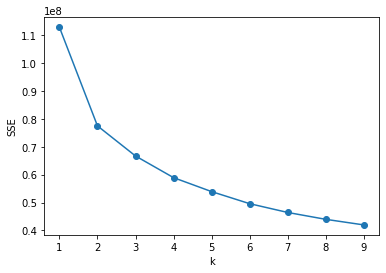

In [168]:
'''Use Elbow Method to choose the cluster number k value'''

#initialize the sum of squared error
SSE=[]
# try different k value
for k in range(1,10):
    estimator =cluster.KMeans(n_clusters=k)
    estimator.fit(np.array(numeric_data))
    SSE.append(estimator.inertia_)
    
#plot the ELBOW graph to find the best k value
X = range(1, 10)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')

* It can be observed that there exists visible clusters in the data. So K-Means might work .let's try it.

###  According the Elbow Method, we choose cluster number k = 2

### I will  extract the variables which are highly positively correlated.

## Step2: Get the data that we need

In [169]:
data_to_cluster = data_df[["Rainfall","WindGustSpeed","Humidity9am", "Humidity3pm", "Cloud9am","Cloud3pm",'RainTomorrow']]

In [170]:
data_to_cluster.head(5)

,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,RainTomorrow
4,1.0,41,82,33,7,8,0
11,2.2,31,89,91,8,8,1
12,15.6,61,76,93,8,8,1
16,0.0,22,69,82,8,1,1
17,16.8,63,80,65,8,1,1


In [171]:
spark = SparkSession.builder.getOrCreate()
km_dfspark = spark.createDataFrame(data_to_cluster)

In [172]:
km_dfspark.printSchema() 

root
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: long (nullable = true)
 |-- Humidity9am: long (nullable = true)
 |-- Humidity3pm: long (nullable = true)
 |-- Cloud9am: long (nullable = true)
 |-- Cloud3pm: long (nullable = true)
 |-- RainTomorrow: long (nullable = true)



In [173]:
km_dfspark.groupBy('RainTomorrow').count().show()

+------------+-----+
|RainTomorrow|count|
+------------+-----+
|           0|56169|
|           1|17242|
+------------+-----+



## Stpe3: Features engineering

In [174]:
# Select feature items and combine feature items into vectors
from pyspark.ml.feature import VectorAssembler
vecAss = VectorAssembler(inputCols = km_dfspark.columns[0:6], outputCol = 'features')
df_kmeans = vecAss.transform(km_dfspark)
df_kmeans.show(3)

+--------+-------------+-----------+-----------+--------+--------+------------+--------------------+
|Rainfall|WindGustSpeed|Humidity9am|Humidity3pm|Cloud9am|Cloud3pm|RainTomorrow|            features|
+--------+-------------+-----------+-----------+--------+--------+------------+--------------------+
|     1.0|           41|         82|         33|       7|       8|           0|[1.0,41.0,82.0,33...|
|     2.2|           31|         89|         91|       8|       8|           1|[2.2,31.0,89.0,91...|
|    15.6|           61|         76|         93|       8|       8|           1|[15.6,61.0,76.0,9...|
+--------+-------------+-----------+-----------+--------+--------+------------+--------------------+
only showing top 3 rows



In [175]:
data_kmeans = df_kmeans.select(["features","RainTomorrow"])
data_kmeans.show(3)

+--------------------+------------+
|            features|RainTomorrow|
+--------------------+------------+
|[1.0,41.0,82.0,33...|           0|
|[2.2,31.0,89.0,91...|           1|
|[15.6,61.0,76.0,9...|           1|
+--------------------+------------+
only showing top 3 rows



## Step4: Train/Test split

In [176]:
datatrain, datatest = data_kmeans.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(datatrain.count()))
print("Test Dataset Count: " + str(datatest.count()))

Training Dataset Count: 51397
Test Dataset Count: 22014


In [177]:
datatrain.describe().show()

+-------+-------------------+
|summary|       RainTomorrow|
+-------+-------------------+
|  count|              51397|
|   mean| 0.2349748039768858|
| stddev|0.42398719680359775|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [178]:
datatest.describe().show()

+-------+-------------------+
|summary|       RainTomorrow|
+-------+-------------------+
|  count|              22014|
|   mean| 0.2346234214590715|
| stddev|0.42377285101077367|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



##  Step5: Build the model of Kmeans
* According the Elbow Method, we choose cluster number k = 2

In [179]:
from pyspark.ml.clustering  import  KMeans

# initialize KMeans object with number of desired clusters
k_means = KMeans(featuresCol='features',k=2)

# fit and transform k_means object to scaled data
kmeans_model = k_means.fit(datatrain)

train_res = kmeans_model.transform(datatrain)
train_res.show(3)

+--------------------+------------+----------+
|            features|RainTomorrow|prediction|
+--------------------+------------+----------+
|[0.0,11.0,85.0,58...|           0|         0|
|[0.0,11.0,87.0,66...|           0|         0|
|[0.0,11.0,92.0,65...|           0|         0|
+--------------------+------------+----------+
only showing top 3 rows



In [180]:
test_res = kmeans_model.transform(datatest)
test_res.show(3)

+--------------------+------------+----------+
|            features|RainTomorrow|prediction|
+--------------------+------------+----------+
|[0.0,13.0,75.0,57...|           0|         0|
|[0.0,13.0,81.0,54...|           0|         0|
|[0.0,13.0,88.0,51...|           0|         0|
+--------------------+------------+----------+
only showing top 3 rows



In [181]:
# Shows the Cluster Centers: .
centers = kmeans_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.18179147 39.1987916  79.02885631 64.00808901  5.50442419  5.43287771]
[ 0.41064949 42.81197593 50.94784215 31.86925008  2.83983135  3.1318395 ]


## Step4: evaluation of model by using test set

In [182]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(test_res)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5371309036170969


# `Regression Classification`

## Build the Logistic Regression Model

### I will  extract the variables which are highly positively correlated. 

## Step1: Get the data that we need

In [183]:
lor_df = data_df[["Rainfall","WindGustSpeed","Humidity9am", "Humidity3pm", "Cloud9am","Cloud3pm",'RainTomorrow']]
spark = SparkSession.builder.getOrCreate()
lor_dfspark = spark.createDataFrame(lor_df)

In [184]:
lor_dfspark.printSchema() 

root
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: long (nullable = true)
 |-- Humidity9am: long (nullable = true)
 |-- Humidity3pm: long (nullable = true)
 |-- Cloud9am: long (nullable = true)
 |-- Cloud3pm: long (nullable = true)
 |-- RainTomorrow: long (nullable = true)



In [185]:
lor_dfspark.show(3)

+--------+-------------+-----------+-----------+--------+--------+------------+
|Rainfall|WindGustSpeed|Humidity9am|Humidity3pm|Cloud9am|Cloud3pm|RainTomorrow|
+--------+-------------+-----------+-----------+--------+--------+------------+
|     1.0|           41|         82|         33|       7|       8|           0|
|     2.2|           31|         89|         91|       8|       8|           1|
|    15.6|           61|         76|         93|       8|       8|           1|
+--------+-------------+-----------+-----------+--------+--------+------------+
only showing top 3 rows



## Stpe2: Features engineering

In [186]:
# Select feature items and combine feature items into vectors
from pyspark.ml.feature import VectorAssembler
vecAss = VectorAssembler(inputCols = lor_dfspark.columns[0:5], outputCol = 'features')
df_lor = vecAss.transform(lor_dfspark)
df_lor.show(3)

+--------+-------------+-----------+-----------+--------+--------+------------+--------------------+
|Rainfall|WindGustSpeed|Humidity9am|Humidity3pm|Cloud9am|Cloud3pm|RainTomorrow|            features|
+--------+-------------+-----------+-----------+--------+--------+------------+--------------------+
|     1.0|           41|         82|         33|       7|       8|           0|[1.0,41.0,82.0,33...|
|     2.2|           31|         89|         91|       8|       8|           1|[2.2,31.0,89.0,91...|
|    15.6|           61|         76|         93|       8|       8|           1|[15.6,61.0,76.0,9...|
+--------+-------------+-----------+-----------+--------+--------+------------+--------------------+
only showing top 3 rows



In [187]:
data_lor = df_lor.select(["features","RainTomorrow"])
data_lor.show(3)

+--------------------+------------+
|            features|RainTomorrow|
+--------------------+------------+
|[1.0,41.0,82.0,33...|           0|
|[2.2,31.0,89.0,91...|           1|
|[15.6,61.0,76.0,9...|           1|
+--------------------+------------+
only showing top 3 rows



## Step3 : Train/Test split

In [188]:
lor_datatrain, lor_datatest = data_lor.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(lor_datatrain.count()))
print("Test Dataset Count: " + str(lor_datatest.count()))

Training Dataset Count: 51374
Test Dataset Count: 22037


In [189]:
lor_datatrain.describe().show()

+-------+-------------------+
|summary|       RainTomorrow|
+-------+-------------------+
|  count|              51374|
|   mean|0.23634523299723595|
| stddev| 0.4248407667422761|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [190]:
lor_datatest.describe().show()

+-------+-------------------+
|summary|       RainTomorrow|
+-------+-------------------+
|  count|              22037|
|   mean|0.23142896038480737|
| stddev| 0.4217554604902293|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



## Step4: Build the Logistic Regression Model and make a prediction of Test dataset

In [191]:
from pyspark.ml.classification import LogisticRegression
lor = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrow', maxIter=10, regParam=0.01)
lorModel = lor.fit(lor_datatrain)

In [192]:
# evaluate on train data
train_pred = lorModel.evaluate(lor_datatrain).predictions
train_pred.select(['features','RainTomorrow','probability','prediction']).show(3)

+--------------------+------------+--------------------+----------+
|            features|RainTomorrow|         probability|prediction|
+--------------------+------------+--------------------+----------+
|[0.0,11.0,85.0,58...|           0|[0.93757789570081...|       0.0|
|[0.0,11.0,87.0,66...|           0|[0.87615185216578...|       0.0|
|[0.0,11.0,92.0,65...|           0|[0.88338379991769...|       0.0|
+--------------------+------------+--------------------+----------+
only showing top 3 rows



In [193]:
train_result = train_pred.toPandas()
train_result_data = train_result[["RainTomorrow","prediction"]]

Confusion matrix for train data:


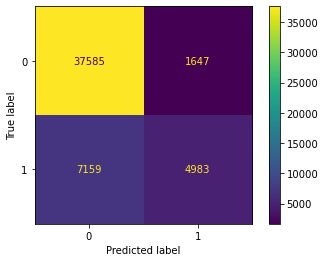

In [194]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(train_result_data["RainTomorrow"], train_result_data["prediction"])
display = ConfusionMatrixDisplay(confusion_matrix=cm,)
print('Confusion matrix for train data:')
display.plot();

* Logistic regression Model correctly identified `37585` Actual number:0 and Predict number:0 (`True Negative - TN`) for train set
* Logistic regression Model correctly identified `4983` Actual number:1 and Predict number:1. (`True Positive - TP`) for train set
* Logistic regression Model incorrectly identified `1647` Actual number:1 but Predict number:0. (`False Negative - FN`) for train set
* Logistic regression Model incorrectly identified `7159` Actual number:0 but Predict number:1. (`False Positive - FP`) for train set

In [195]:
# evaluate on test data
test_result = lorModel.evaluate(lor_datatest).predictions
test_result.select(['features','RainTomorrow','probability','prediction']).show(3)

+--------------------+------------+--------------------+----------+
|            features|RainTomorrow|         probability|prediction|
+--------------------+------------+--------------------+----------+
|[0.0,11.0,100.0,6...|           0|[0.89374439670615...|       0.0|
|[0.0,13.0,69.0,60...|           0|[0.86552231950389...|       0.0|
|[0.0,13.0,75.0,57...|           0|[0.84344946148804...|       0.0|
+--------------------+------------+--------------------+----------+
only showing top 3 rows



In [196]:
test_data = test_result.toPandas()
test_result_data = test_data[["RainTomorrow","prediction"]]

Confusion matrix for train data:


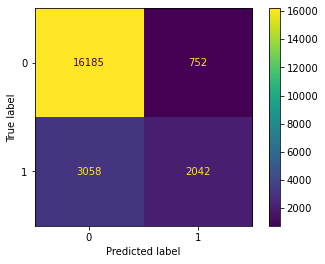

In [197]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(test_result_data["RainTomorrow"], test_result_data["prediction"])
display = ConfusionMatrixDisplay(confusion_matrix=cm,)
print('Confusion matrix for train data:')
display.plot();

* Logistic regression Model correctly identified `16185` Actual number:0 and Predict number:0 (`True Negative - TN`) for test set
* Logistic regression Model correctly identified `2042` Actual number:1 and Predict number:1. (`True Positive - TP`) for test set
* Logistic regression Model incorrectly identified `752` Actual number:1 but Predict number:0. (`False Negative - FN`) for test set
* Logistic regression Model incorrectly identified `3058` Actual number:0 but Predict number:1. (`False Positive - FP`) for test set

## step5: Logistic Regression Model evaluation

In [198]:
from sklearn.metrics import classification_report, confusion_matrix

predictions_train = lorModel.transform(lor_datatrain)

Actual_data = predictions_train.select(['RainTomorrow']).collect()
pre_data = predictions_train.select(['prediction']).collect()

# '0' = RainTomorrow(No),'1'= RainTomorrow(Yes)
print(classification_report(Actual_data, pre_data, target_names=['0', '1'], digits=6))

              precision    recall  f1-score   support

           0   0.840001  0.958019  0.895137     39232
           1   0.751584  0.410394  0.530897     12142

    accuracy                       0.828590     51374
   macro avg   0.795792  0.684206  0.713017     51374
weighted avg   0.819104  0.828590  0.809050     51374



## step6 : plot the ROC figure of train set

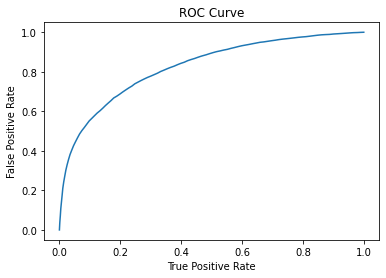

Training set areaUnderROC: 0.8251712519226


In [199]:
trainingSum = lorModel.summary

lr_roc = trainingSum.roc.toPandas()
plt.plot(lr_roc['FPR'],lr_roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSum.areaUnderROC))